# Data Preparation

Run this notebook to prepare the dataset for the models.

The prepared data are saved in a HDF5 file in the folder `./additional_data`

In [1]:
#!/usr/bin/env python
# coding: utf-8
# (c) Charles Le Losq, Clément Ferraina 2023-2024
# see embedded licence file
# iVisc 1.0

#
# Library Loading
#
import pandas as pd # manipulate dataframes
import matplotlib.pyplot as plt # plotting
import numpy as np
np.random.seed = 167 # fix random seed for reproducibility

# local imports
import gpvisc


2024-06-26 15:43:34.446669: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-26 15:43:34.468963: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-26 15:43:34.852956: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Code for random seed selection

## Observe the statistical distribution of the features

Are the train, validation and test sets similar ? They should be... If the data distribution differs too much, it is obvious that the training will not be optimal. Therefore before doing anything, we must split the datasets in a sensible way.

A way to do it is to play with the random seed until the feature distributions of the train, validation and testing subsets look similar. I got inspired by this blog post to do so:
https://www.yourdatateacher.com/2022/05/02/are-your-training-and-test-sets-comparable/

In the blog post, they basically compare the Kolmogorov-Smirnov distance between the different data subsets and select a random seed that allows having a minimal distance.

I modified this to adopt a slightly different but similar approach: measure the Wasserstein distance for each feature, take the mean and its standard deviation, and select 10 seeds based on this metric.

First, we can look at some features. What do their cumulative distributions look like:

Reading data...
Preparing the 1 bar dataset with stratified group splitting...


Unique compositions in the train, valid and test subsets:
train 4442, valid 554, test 555
this makes:
train 80.0%, valid 10.0%, test 10.0%

Detection of group (composition) leackage: between
 and train-test:
0 leacked composition between train and valid subsets
0 leacked composition between train and test subsets
Preparing now the high pressure dataset, using train__test_split from Scikit-Learn...
The total number of unique compositions is 205.
Size of viscous training subsets:

(23235, 155)
(2807, 155)
(2856, 155)
Loaded.


<Axes: xlabel='0', ylabel='Proportion'>

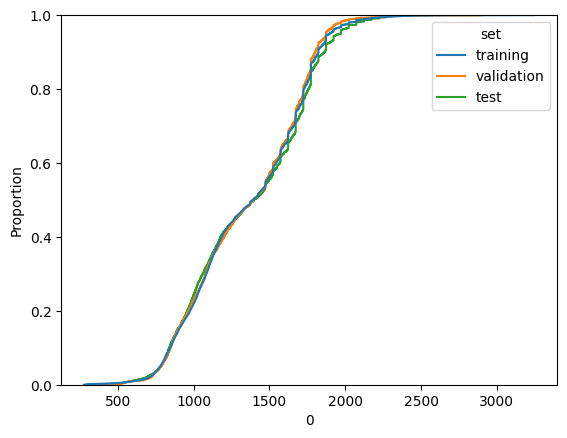

In [2]:
# let's first import and prepare the dataset with a given arbitrary random seed, here 37:
ds = gpvisc.data_loader(pretreat_data=True, pretreat_path='./additional_data/', rand_state=37)
print("Loaded.")

# we can now observe the distributions:
import seaborn as sns
feature_ = 0

df = pd.DataFrame({
    feature_:np.concatenate((ds.TPX_train[:,feature_],
                                 ds.TPX_valid[:,feature_],
                                 ds.TPX_test[:,feature_])),
    'set':['training']*ds.TPX_train.shape[0] 
          + ['validation']*ds.TPX_valid.shape[0]
          + ['test']*ds.TPX_test.shape[0]
    })
sns.ecdfplot(data=df,x=feature_,hue='set')

The Wasserstein distance is a way to mesure the distance between those curves basically.

To select seeds, we draw 500 times different random seeds, and select the 10 ones that have the minimal average Wasserstein distance.

In [14]:
from scipy.stats import ks_2samp, wasserstein_distance_nd, wasserstein_distance
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

n_tries = 500

result = []

for random_state in tqdm(np.random.randint(1,10000,n_tries)):
    ds = gpvisc.data_loader(pretreat_path='./additional_data/', pretreat_data=True, verbose=False, rand_state=random_state)

    # let's scale the data to avoid bias in the wasserstein distance calculation
    scaler = StandardScaler().fit(ds.TPX_train)
    ds.TPX_train_scaled = scaler.transform(ds.TPX_train)
    ds.TPX_valid_scaled = scaler.transform(ds.TPX_valid)
    ds.TPX_test_scaled = scaler.transform(ds.TPX_test) 

    # now we calculate the distance for the 14 first columns (T, P and composition X)
    distances_train_valid = list(map(lambda i : wasserstein_distance(ds.TPX_train_scaled[:,i],ds.TPX_valid_scaled[:,i]),range(0,14)))
    distances_train_test = list(map(lambda i : wasserstein_distance(ds.TPX_train_scaled[:,i],ds.TPX_test_scaled[:,i]),range(0,14)))
    # below is an attempt with the wasserstein_distance_nd function but it crashes the kernel!
    #distances_train_valid = wasserstein_distance_nd(ds.TPX_train[:,0:14], ds.TPX_valid[:,0:14])
    # = wasserstein_distance_nd(ds.TPX_train[:,0:14], ds.TPX_test[:,0:14])

    # we take the average value and the standard devviaiton
    result.append((random_state,
                   np.mean(distances_train_valid),
                   np.std(distances_train_valid),
                   np.mean(distances_train_test),
                   np.std(distances_train_test)))

  0%|          | 2/500 [00:01<07:02,  1.18it/s]/home/charles/miniconda3/envs/gpytorch/lib/python3.11/site-packages/sklearn/model_selection/_split.py:994: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
 11%|█         | 54/500 [00:45<06:17,  1.18it/s]/home/charles/miniconda3/envs/gpytorch/lib/python3.11/site-packages/sklearn/model_selection/_split.py:994: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
 12%|█▏        | 61/500 [00:51<06:09,  1.19it/s]/home/charles/miniconda3/envs/gpytorch/lib/python3.11/site-packages/sklearn/model_selection/_split.py:994: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
 13%|█▎        | 63/500 [00:52<06:04,  1.20it/s]/home/charles/miniconda3/envs/gpytorch/lib/python3.11/site-packages/sklearn/model_selection/_split.py:994: UserWarning: The least populated class in y h

Now we sort this list and get the random seed that allows obtaining a minimal Wasserstein distance among the features in the train, validation and testing subsets.

In [15]:
db_result = pd.DataFrame(result, columns=["seed", 
                                          "train_valid_mean", 
                                          "train_valid_std", 
                                          "train_test_mean", 
                                          "train_test_std"])
db_result["mean"] = (db_result["train_valid_mean"]+db_result["train_test_mean"])/2
db_result["std"] = (db_result["train_valid_std"]+db_result["train_test_std"])/2

# we want seeds that provide a good average Wasserstein distance
# as well as comparable distanes between features
# so we will work on the sum of the mean and std for selection
db_result["mean_std"] = db_result["mean"]+db_result["std"]
db_best = db_result.nsmallest(10, ["mean_std", "train_test_mean"]).copy().reset_index()
db_best

,index,seed,train_valid_mean,train_valid_std,train_test_mean,train_test_std,mean,std,mean_std
0,361,6428,0.051557,0.020188,0.040023,0.014679,0.045790,0.017433,0.063223
1,34,3720,0.045122,0.014899,0.053762,0.021474,0.049442,0.018187,0.067629
2,325,8299,0.053132,0.019612,0.050859,0.012584,0.051996,0.016098,0.068094
3,200,650,0.053010,0.020826,0.045523,0.016969,0.049267,0.018897,0.068164
4,291,6961,0.043759,0.018689,0.052197,0.022786,0.047978,0.020738,0.068715
5,380,6025,0.044378,0.016059,0.050139,0.027277,0.047258,0.021668,0.068926
6,40,6122,0.048269,0.019478,0.049977,0.021331,0.049123,0.020405,0.069527
7,211,2626,0.044547,0.018263,0.052025,0.025593,0.048286,0.021928,0.070214
8,6,6360,0.050197,0.021331,0.052129,0.016898,0.051163,0.019115,0.070278
9,78,4628,0.046992,0.025667,0.047632,0.021589,0.047312,0.023628,0.070940


we can select one of those seeds as a good starting point.

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import root_mean_squared_error

db_best["MLP_train"] = 0.0
db_best["MLP_valid"] = 0.0
db_best["MLP_test"] = 0.0

for count, seed_ in enumerate(db_best.seed):
    ds = gpvisc.data_loader(pretreat_path='./additional_data/', 
                            pretreat_data=True, 
                            rand_state=seed_,
                            verbose=False)
    
    # preparing data scaling
    scaler = StandardScaler().fit(ds.TPX_train)
    ds.TPX_train_scaled = scaler.transform(ds.TPX_train)
    ds.TPX_valid_scaled = scaler.transform(ds.TPX_valid)
    ds.TPX_test_scaled = scaler.transform(ds.TPX_test)  

    # train a neural network
    clf_nn = MLPRegressor(solver='adam', 
                      alpha=1e-3, 
                      hidden_layer_sizes=(20, ),
                      activation='relu', 
                      max_iter=100,
                      random_state=1
                      )

    clf_nn.fit(ds.TPX_train_scaled, ds.y_train.ravel())
    y_train_pred = clf_nn.predict(ds.TPX_train_scaled)
    y_valid_pred = clf_nn.predict(ds.TPX_valid_scaled)
    y_test_pred = clf_nn.predict(ds.TPX_test_scaled)

    db_best.loc[count,"MLP_train"] = root_mean_squared_error(ds.y_train.ravel(),y_train_pred)
    db_best.loc[count,"MLP_valid"] = root_mean_squared_error(ds.y_valid.ravel(),y_valid_pred)
    db_best.loc[count,"MLP_test"] = root_mean_squared_error(ds.y_test.ravel(),y_test_pred)

/home/charles/miniconda3/envs/gpytorch/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/charles/miniconda3/envs/gpytorch/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/charles/miniconda3/envs/gpytorch/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/charles/miniconda3/envs/gpytorch/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't conv

In [19]:
db_best["sum"] = db_best.MLP_valid + db_best.MLP_test
db_best.sort_values(by= ["sum"])

,index,seed,train_valid_mean,train_valid_std,train_test_mean,train_test_std,mean,std,mean_std,MLP_train,MLP_valid,MLP_test,sum
6,40,6122,0.048269,0.019478,0.049977,0.021331,0.049123,0.020405,0.069527,0.522234,0.663312,0.563235,1.226547
3,200,650,0.053010,0.020826,0.045523,0.016969,0.049267,0.018897,0.068164,0.519618,0.581960,0.677082,1.259043
5,380,6025,0.044378,0.016059,0.050139,0.027277,0.047258,0.021668,0.068926,0.514336,0.624713,0.646027,1.270740
8,6,6360,0.050197,0.021331,0.052129,0.016898,0.051163,0.019115,0.070278,0.514260,0.682654,0.603530,1.286184
4,291,6961,0.043759,0.018689,0.052197,0.022786,0.047978,0.020738,0.068715,0.531074,0.630896,0.656511,1.287407
7,211,2626,0.044547,0.018263,0.052025,0.025593,0.048286,0.021928,0.070214,0.512679,0.667129,0.628608,1.295736
0,361,6428,0.051557,0.020188,0.040023,0.014679,0.045790,0.017433,0.063223,0.525276,0.629593,0.673302,1.302894
1,34,3720,0.045122,0.014899,0.053762,0.021474,0.049442,0.018187,0.067629,0.514042,0.688276,0.630924,1.319200
2,325,8299,0.053132,0.019612,0.050859,0.012584,0.051996,0.016098,0.068094,0.522414,0.618406,0.712259,1.330664
9,78,4628,0.046992,0.025667,0.047632,0.021589,0.047312,0.023628,0.070940,0.522495,0.763773,0.647577,1.411350


and let's have a quick look at the cumulative distribution of some feature

<Axes: xlabel='4', ylabel='Proportion'>

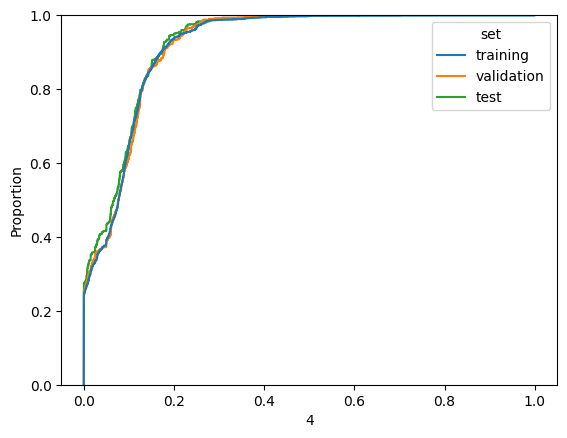

In [20]:
ds = gpvisc.data_loader(pretreat_path='./additional_data/', 
                            pretreat_data=True, 
                            rand_state=6122,
                            verbose=False)
import seaborn as sns
feature_ = 4

df = pd.DataFrame({
    feature_:np.concatenate((ds.TPX_train[:,feature_],
                                 ds.TPX_valid[:,feature_],
                                 ds.TPX_test[:,feature_])),
    'set':['training']*ds.TPX_train.shape[0] 
          + ['validation']*ds.TPX_valid.shape[0]
          + ['test']*ds.TPX_test.shape[0]
    })
sns.ecdfplot(data=df,x=feature_,hue='set')

We can also look at the viscosity vs temperature coverage. One key thing: silica should be in the training set. If not, it is doomed to fail as it is a critical endmember composition.

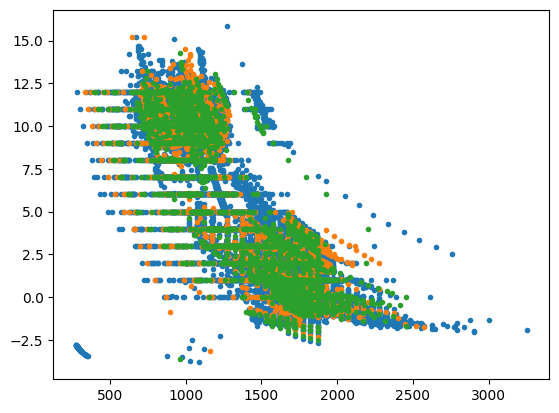

In [21]:
plt.plot(ds.T_train, ds.y_train,".")
plt.plot(ds.T_valid, ds.y_valid,".")
plt.plot(ds.T_test, ds.y_test,".")